In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Utils and data generation

In [2]:
def make_poly(x, D):
  x = x.reshape(-1,1)
  N = len(x)
  poly = PolynomialFeatures(D)
  x = poly.fit_transform(x)
  if (D > 1):
    scaler = StandardScaler()
    x[:, 2:] = scaler.fit_transform(x[:, 2:])
  return x

In [3]:
NUM_DATASETS = 50
NOISE_STD = 0.5
NOISE_VARIANCE = NOISE_STD ** 2
MAX_POLY = 12
N = 25 # 1000
Ntrain = int(0.9*N)
np.random.seed(2)
f = lambda x: np.sin(x)

# Colculations

In [4]:
X = np.linspace(-np.pi, np.pi, N)
np.random.shuffle(X)
#f_X = f(X)
#X_poly = make_poly(X, MAX_POLY)
X_experiments = np.zeros((N, NUM_DATASETS))
x_axis = np.linspace(-np.pi, np.pi, 100)

def simulate_experiments(x_randomisation=True):
  model = LinearRegression()
  for k in range(NUM_DATASETS):
    if (x_randomisation == True):
      np.random.shuffle(X)
    f_X = f(X)
    X_poly = make_poly(X, MAX_POLY)

    Y = f_X + np.random.randn(N) * NOISE_STD
    X_train, X_test = X_poly[:Ntrain], X_poly[Ntrain:]
    Y_train, Y_test = Y[:Ntrain], Y[Ntrain:]
    X_experiments[:, k] = X

    for d in range(MAX_POLY):
      model.fit(X_train[:, :d+2], Y_train)
      Y_train_hat = model.predict(X_train[:, :d+2])
      Y_test_hat = model.predict(X_test[:, :d+2])
      train_predictions[:, k, d] = Y_train_hat
      test_predictions[:, k, d] = Y_test_hat

      train_scores[k,d] = mse(Y_train_hat, Y_train)
      test_scores[k,d] = mse(Y_test_hat, Y_test)


      x_axis_poly = make_poly(x_axis, d+1)
      prediction_curves[:, k, d] = model.predict(x_axis_poly)

In [5]:
train_scores = np.zeros((NUM_DATASETS, MAX_POLY))
test_scores = np.zeros((NUM_DATASETS, MAX_POLY))
squared_biases = np.zeros((NUM_DATASETS, MAX_POLY))
test_predictions = np.zeros((N - Ntrain, NUM_DATASETS, MAX_POLY))
train_predictions = np.zeros((Ntrain, NUM_DATASETS, MAX_POLY))
prediction_curves = np.zeros((100, NUM_DATASETS, MAX_POLY))

simulate_experiments(x_randomisation=False)

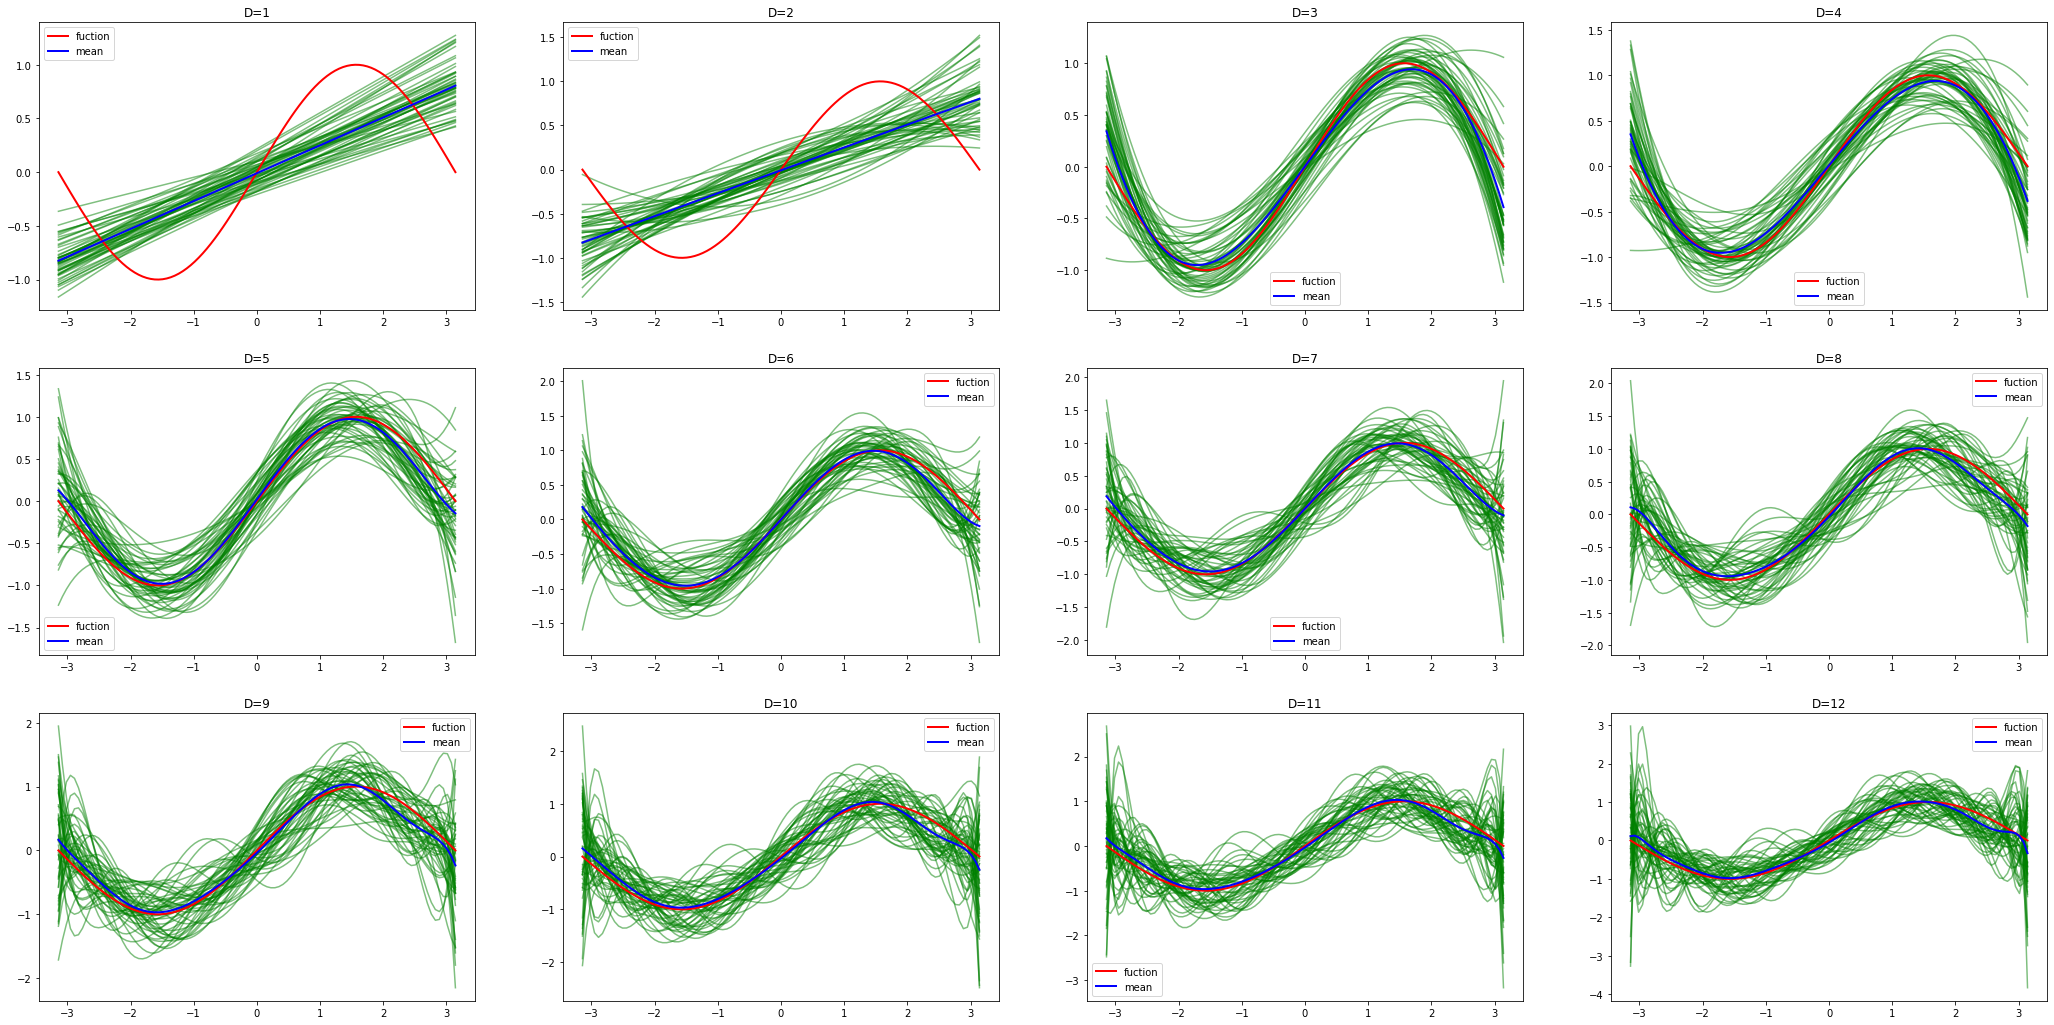

In [6]:
plots_width = 4
fig, axs = plt.subplots(MAX_POLY//plots_width, plots_width, figsize=(36,18))
for d in range(MAX_POLY):
  for k in range(NUM_DATASETS):
    axs[d // plots_width, d % plots_width].plot(x_axis, prediction_curves[:, k, d], color='green', alpha=0.5)
  axs[d // plots_width, d % plots_width].plot(x_axis, f(x_axis), color='red', linewidth=2.0, label='fuction')
  axs[d // plots_width, d % plots_width].plot(x_axis, prediction_curves[:, :, d].mean(axis=1), color='blue', linewidth=2.0, label='mean')
  axs[d // plots_width, d % plots_width].set_title(f'D={d+1}')
  axs[d // plots_width, d % plots_width].legend()
plt.show();

## Calculate quared bias and variance

In [7]:
def calc_bias_variance_for_randomisation(predictions, true_trend_func, x): # this works incorrectly bacause it aggregates points x by position where it can be diffetered x poins under each position of X_experiments on each experiment in NUM_DATASETS
  # to fix this we should calculate mean of predection in each x whic his not guarateed that this x is in test data in some of hte experiments

  N, K, D = predictions.shape
  #print(predictions.shape)
  squared_bias = np.zeros((N, MAX_POLY))
  variance = np.zeros((N, MAX_POLY))

  for d in range(D):
    mean_predictions = predictions[:, :, d].mean(axis=1)
    errors_mean = (true_trend_func(x) - mean_predictions.reshape(-1,1))
    #print(errors_mean.shape)
    squared_bias[:, d] = np.power(errors_mean, 2).mean(axis=1)

    variance[:, d] = np.power(predictions[:, :, d] - mean_predictions.reshape(-1,1), 2).mean(axis=1)

  mean_squared_bias = squared_bias.mean(axis=0)
  mean_variance = variance.mean(axis=0)

  return mean_squared_bias, mean_variance, pd.DataFrame(np.stack((np.arange(1,13), mean_squared_bias, mean_variance)).T, columns=['degree', 'E(squared_bias)', 'E(total variance)'])

# _, _, bv_df = calc_bias_variance_for_randomisation(train_predictions, f, X_experiments[:Ntrain, :])#np.tile(X, (train_predictions.shape[1],1)))
# bv_df

In [8]:
# the below doent work correctly as we do not randomise X on each experiment, so we only randomize error eps; for small numper of N this can lead to very dab predictiors on edge of regions because the whole mass of train data can be on the other side of the region; 
# check plot with by running below for small numer of N:
# simulate_experiments(x_randomisation=True)

squared_bias = np.zeros((Ntrain, MAX_POLY))
variance = np.zeros((Ntrain, MAX_POLY))

bias = np.zeros(MAX_POLY)
for d in range(MAX_POLY):
  mean_predictions = train_predictions[:, :, d].mean(axis=1)
  erors_mean = f(X[:Ntrain]) - mean_predictions
  squared_bias[:, d] = np.power(erors_mean, 2)

  variance[:, d] = np.power(train_predictions[:, :, d] - mean_predictions.reshape(-1,1), 2).mean(axis=1)

print(squared_bias.shape)
mean_squared_bias = squared_bias.mean(axis=0)
mean_variance = variance.mean(axis=0)

pd.DataFrame(np.stack((np.arange(1,13), mean_squared_bias, mean_variance)).T, columns=['degree', 'E(squared_bias)', 'E(total variance)'])

(22, 12)


,degree,E(squared_bias),E(total variance)
0,1.0,0.226017,0.022148
1,2.0,0.226044,0.031596
2,3.0,0.005843,0.045369
3,4.0,0.005885,0.051921
4,5.0,0.000534,0.061711
5,6.0,0.000835,0.071044
6,7.0,0.000817,0.081851
7,8.0,0.001404,0.090143
8,9.0,0.001780,0.100199
9,10.0,0.001791,0.113715


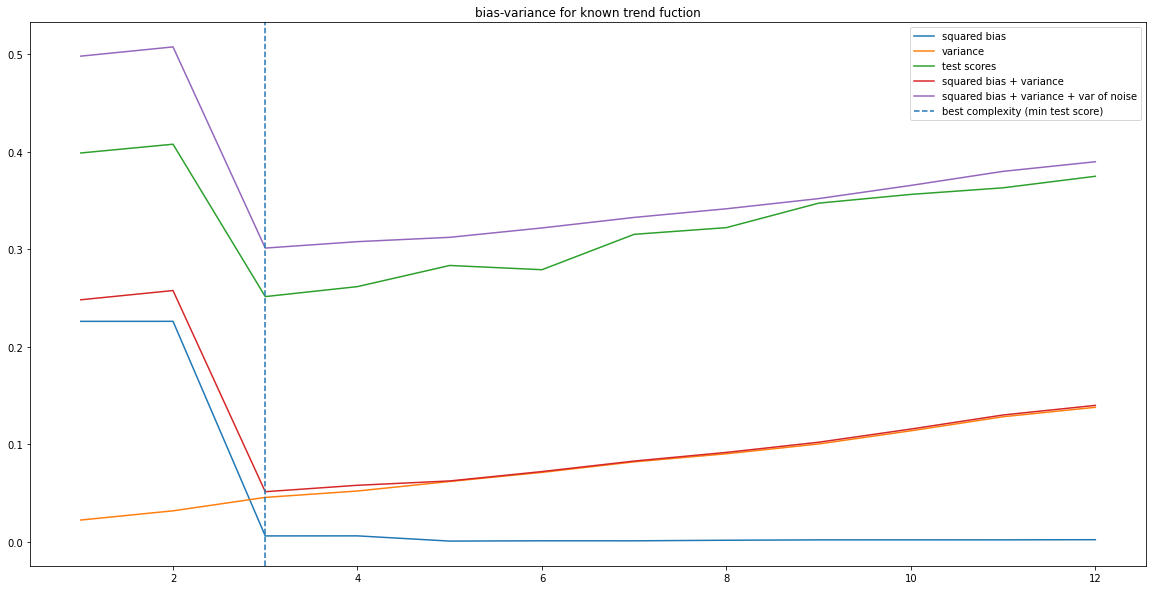

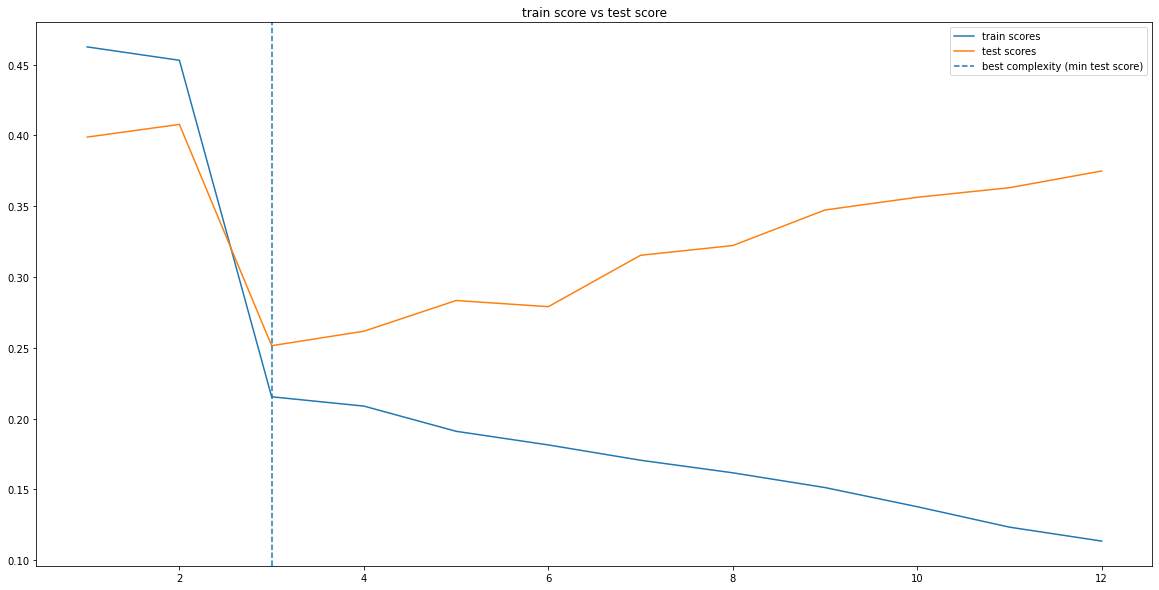

In [9]:
degrees = np.arange(MAX_POLY) + 1
best_degree = np.argmin(test_scores.mean(axis=0)) + 1

plt.figure(figsize=(20,10))
plt.plot(degrees, mean_squared_bias, label='squared bias')
plt.plot(degrees, mean_variance, label='variance')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.plot(degrees, mean_squared_bias + mean_variance, label='squared bias + variance')
plt.plot(degrees, mean_squared_bias + mean_variance + NOISE_VARIANCE, label='squared bias + variance + var of noise')
plt.axvline(x=best_degree, linestyle='--', label='best complexity (min test score)')
plt.legend()
plt.title('bias-variance for known trend fuction')
plt.show()


plt.figure(figsize=(20,10))
plt.plot(degrees, train_scores.mean(axis=0), label='train scores')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.axvline(x=best_degree, linestyle='--', label='best complexity (min test score)')
plt.legend()
plt.title('train score vs test score')
plt.show()